In [1]:
# Running RandomForest regressions to discover a lifters best lift
# across the 3 lifts.
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.datasets import load_digits

In [2]:
# Sampling 20,000 data entries
n = 767672 
s = 20000
skip = sorted(random.sample(range(1,n+1),n-s))
data = pd.read_csv('zeroopenpowerlifting.csv', skiprows=skip)
data

,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,...,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date
0,Amy Moldenhauer,F,SBD,Wraps,23.0,20-23,F-OR,60.00,60,0.0,...,310.0,3,345.61,345.61,305.37,547.04,NaN,NaN,GPC-AUS,2018-10-27
1,Joanne Lawrence,F,SBD,Wraps,48.0,45-49,F-OR,55.80,56,115.0,...,362.5,2,427.72,469.21,378.36,667.69,NaN,NaN,GPC-AUS,2018-10-27
2,Damir Matecic,M,SBD,Wraps,35.0,35-39,M-OR,137.80,140,280.0,...,825.0,3,462.13,462.13,438.13,632.54,NaN,NaN,GPC-AUS,2018-10-27
3,David Soon,M,SBD,Wraps,27.0,24-34,M-OR,66.80,67.5,130.0,...,400.0,2,311.01,311.01,301.77,437.84,NaN,NaN,GPC-AUS,2018-10-27
4,Kris Miles,M,SBD,Wraps,24.0,24-34,M-OR,89.20,90,180.0,...,557.5,10,357.54,357.54,344.62,521.87,NaN,NaN,GPC-AUS,2018-10-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Joe Abramovich,M,B,Multi-ply,24.0,24-34,Open,108.41,110,0.0,...,320.0,1,189.18,189.18,180.74,753.25,Yes,NaN,365Strong,2019-05-11
19996,Lucas Pribble,M,B,Single-ply,24.0,24-34,M-OB-SP-T,87.08,90,0.0,...,217.5,1,141.28,141.28,135.60,634.56,Yes,USA,365Strong,2019-12-21
19997,Michael Brickhill,M,B,Raw,51.0,50-54,M-M3B-R-X,81.87,82.5,0.0,...,100.0,1,67.30,77.19,64.78,410.43,NaN,NaN,365Strong,2019-12-21
19998,Terri VandeVegte,F,BD,Raw,59.0,55-59,wmp,133.54,90+,0.0,...,255.0,1,200.04,263.05,168.67,NaN,Yes,USA,NASA,2019-11-09


In [3]:
# Dropping columns not needed for this test
data = data.drop(columns=['Name', 'AgeClass', 'Division',
                          'Squat4Kg', 'Bench4Kg', 'Deadlift4Kg',
                          'Place', 'Tested', 'Country', 'Federation',
                          'Date', 'IPFPoints', 'TotalKg', 'Squat1Kg',
                          'Squat2Kg', 'Squat3Kg','Bench1Kg', 'Bench2Kg',
                          'Bench3Kg', 'Deadlift1Kg', 'Deadlift2Kg',
                          'Deadlift3Kg', 'McCulloch', 'Glossbrenner',
                          'WeightClassKg'])

data.columns
data.isnull().sum()

Sex                   0
Event                 0
Equipment             0
Age                   0
BodyweightKg          0
Best3SquatKg          0
Best3BenchKg          0
Best3DeadliftKg       0
Wilks              1192
dtype: int64

In [4]:
# General dropna just  to clear those without a WILKS
data = data.dropna()

In [5]:
# Dropping athletes who did not compete in complete SBD competitions
indexNames = data[data['Event'] == 'S'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'B'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'D'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'SD'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'SB'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'BD'].index
data.drop(indexNames, inplace=True)

In [6]:
# Remove the last couple of columns
data = data.drop(columns = ['Event'])

In [7]:
data

,Sex,Equipment,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Wilks
0,F,Wraps,23.0,60.00,105.00,72.50,132.50,345.61
1,F,Wraps,48.0,55.80,122.50,82.50,157.50,427.72
2,M,Wraps,35.0,137.80,300.00,210.00,315.00,462.13
3,M,Wraps,27.0,66.80,150.00,90.00,160.00,311.01
4,M,Wraps,24.0,89.20,207.50,135.00,215.00,357.54
...,...,...,...,...,...,...,...,...
19985,M,Single-ply,18.5,54.52,127.01,61.23,122.47,290.46
19986,M,Raw,18.0,72.85,150.00,90.00,180.00,305.52
19990,F,Raw,27.0,112.49,117.50,65.00,145.00,265.06
19991,M,Raw,45.0,82.10,245.00,147.50,245.00,428.32


In [8]:
# Convert string data to numeric
sex = {'M': 1, 'F': 0, 'Mx': 3}
equipment = {'Raw': 0, 'Wraps': 1, 'Multi-ply': 2, 'Single-ply': 3, 'Straps': 4}

data.Sex = [sex[item] for item in data.Sex]
data.Equipment = [equipment[item] for item in data.Equipment]

data

,Sex,Equipment,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Wilks
0,0,1,23.0,60.00,105.00,72.50,132.50,345.61
1,0,1,48.0,55.80,122.50,82.50,157.50,427.72
2,1,1,35.0,137.80,300.00,210.00,315.00,462.13
3,1,1,27.0,66.80,150.00,90.00,160.00,311.01
4,1,1,24.0,89.20,207.50,135.00,215.00,357.54
...,...,...,...,...,...,...,...,...
19985,1,3,18.5,54.52,127.01,61.23,122.47,290.46
19986,1,0,18.0,72.85,150.00,90.00,180.00,305.52
19990,0,0,27.0,112.49,117.50,65.00,145.00,265.06
19991,1,0,45.0,82.10,245.00,147.50,245.00,428.32


In [9]:
# Normalise the data, scaling to values between 0-1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
data[['Sex', 'Age', 'Equipment', 'BodyweightKg',
        'Wilks', 'Best3BenchKg', 'Best3DeadliftKg', 'Best3SquatKg']] = scaler.fit_transform(data[['Sex', 'Age', 'Equipment', 'BodyweightKg',
        'Wilks', 'Best3BenchKg', 'Best3DeadliftKg', 'Best3SquatKg']])

In [10]:
# So, running 3 different test and training sets.
# First for squats, then bench, finally deadlifts,
# See the model accuracy for predicting someone's lifts.
# Further experiments to see which variables are critical
# to accurate prediction. How accurate can we get with age,
# sex, weight, and equipment?

test_squat = data[[ 'Sex', 'Age', 'BodyweightKg', 'Equipment', 'Best3BenchKg', 'Best3DeadliftKg','Wilks']]

target_squat = data[['Best3SquatKg']]

test_bench = data[['Sex', 'Age', 'BodyweightKg', 'Equipment', 'Wilks']]

target_bench = data[['Best3BenchKg']]

test_dead = data[['Sex', 'Age', 'BodyweightKg', 'Equipment', 'Wilks']]

target_dead = data[['Best3DeadliftKg']]

In [11]:
# Preparing sets
S = test_squat
s = target_squat
B = test_bench
b = target_bench
D = test_dead
d = target_dead

In [23]:
# Split sets into training and test sets
from sklearn.model_selection import train_test_split
S_train, S_test, s_train, s_test = train_test_split(S, s, test_size=0.1, random_state=3)
B_train, B_test, b_train, b_test = train_test_split(B, b, test_size=0.1, random_state=3)
D_train, D_test, d_train, d_test = train_test_split(D, d, test_size=0.1, random_state=3)

In [24]:
# Prepare model, then fit the models and check scores!
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, max_depth = 30)

In [25]:
model.fit(S_train, s_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [26]:
S_pred = model.predict(S_test)
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(S_pred , s_test))

R2-score: 0.97


In [16]:
model.fit(B_train, b_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [17]:
B_pred = model.predict(B_test)
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(B_pred , b_test))

R2-score: 0.90


In [18]:
model.fit(D_train, d_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [19]:
D_pred = model.predict(D_test)
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(D_pred , d_test))

R2-score: 0.93


In [27]:
s_pred = pd.DataFrame(model.predict(S_test))
S_bw = pd.DataFrame(S_test['BodyweightKg'])
S_bw = S_bw.reset_index()
s_pred = s_pred.reset_index()
S_bw = S_bw.drop(columns = 'index')
s_pred = s_pred.drop(columns = 'index')
s_t = s_test.reset_index()
s_t = s_t.drop(columns = 'index')

<ipython-input-28-c2260e31b8e6>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  yfit = RandomForestRegressor().fit(S_bw, s_pred).predict(xfit[:, None])
<ipython-input-28-c2260e31b8e6>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  zfit = RandomForestRegressor().fit(S_bw, s_test).predict(xfit[:, None])


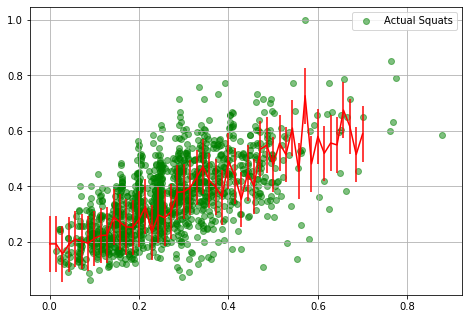

In [28]:
xfit = np.linspace(0, 0.7)
yfit = RandomForestRegressor().fit(S_bw, s_pred).predict(xfit[:, None])
zfit = RandomForestRegressor().fit(S_bw, s_test).predict(xfit[:, None])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(S_bw, s_test, color = 'g', label='Actual Squats', alpha=0.5)
#plt.plot(xfit, yfit, '-r', color='red', label='Pred')
#plt.plot(xfit, zfit, '-k', color='blue', label='Real')
plt.errorbar(xfit, yfit, 0.1, fmt='r')
ax.legend()
ax.grid(True)
plt.show()

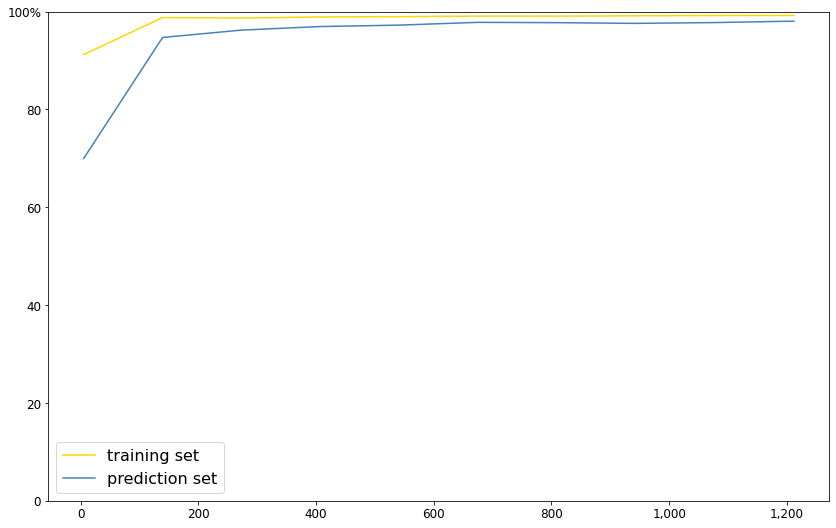

In [30]:
    from sklearn import metrics
    from matplotlib.ticker import FuncFormatter
    
    training_set_sizes = np.linspace(5, len(S_bw), 10, dtype='int')
    
    train_score = []
    pred_score = []
    
    for i in training_set_sizes:
        
        model.fit(S_train.iloc[0:i, :], s_train.iloc[0:i].values.ravel())
        
        t_acc = model.score(S_train.iloc[0:i, :], s_train.iloc[0:i])
        p_acc = model.score(S_test.iloc[0:i, :], s_pred.iloc[0:i])
        
        train_score.append(t_acc)
        pred_score.append(p_acc)
       
    # plot learning curves
    fig, ax = plt.subplots(figsize=(14, 9))
    ax.plot(training_set_sizes, train_score, c='gold')
    ax.plot(training_set_sizes, pred_score, c='steelblue')

    # format the chart to make it look nice
    #fig.suptitle(suptitle, fontweight='bold', fontsize='20')
    #ax.set_title(title, size=20)
    #ax.set_xlabel(xlabel, size=16)
    #ax.set_ylabel(ylabel, size=16)
    ax.legend(['training set', 'prediction set'], fontsize=16)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylim(0, 1)

    def percentages(x, pos):
        """The two args are the value and tick position"""
        if x < 1:
            return '{:1.0f}'.format(x*100)
        return '{:1.0f}%'.format(x*100)

    def numbers(x, pos):
        """The two args are the value and tick position"""
        if x >= 1000:
            return '{:1,.0f}'.format(x)
        return '{:1.0f}'.format(x)

    y_formatter = FuncFormatter(percentages)
    ax.yaxis.set_major_formatter(y_formatter)

    x_formatter = FuncFormatter(numbers)
    ax.xaxis.set_major_formatter(x_formatter)